# For classification...
using titanic dataset

# Libraries

In [1]:
# basics
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import json
import time
import datetime
import os
import sys
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold

# visualize
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib_venn import venn2
import seaborn as sns
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter
import plotly.figure_factory as ff
import plotly.express as px
import missingno as msno

sns.set_context("talk")
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
style.use('fivethirtyeight')

# custom EDA functions
mypath = os.getcwd()
sys.path.append(mypath + '/code/') 
from utils import reduce_mem_usage
from categorical_encoder import label_encoding
from feature_converter import categorize_features
from catplot import CategoricalVisualizer
from denseplot import DenseVisualizer

# custom modeling functions
sys.path.append(mypath + '/cls_models/') 
from base_classifier import ClassifierBase
from lgb_classifier import LgbClassifier
from catb_classifier import CatbClassifier

# stats
from scipy import stats
from sklearn.metrics import cohen_kappa_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.model_selection import train_test_split
import scipy as sp
from functools import partial
from collections import Counter

pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore')

print("libraries imported")

libraries imported


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning:

Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.



# Load data

In [2]:
!ls

EDA.ipynb            EDA_titanic.ipynb    inputs
EDA_houseprice.ipynb cls_models           reg_models
EDA_laputa.ipynb     code


In [3]:
# check path
datapath = "inputs/"
files = os.listdir(datapath)
print(files)

['.DS_Store', 'atma2020', 'house-prices-advanced-regression-techniques', 'titanic']


In [4]:
datapath = datapath + 'titanic'
os.listdir(datapath)

['test.csv', 'train.csv', 'gender_submission.csv']

In [5]:
# import data
time0 = time.time()

train = pd.read_csv(datapath + '/train.csv')
test = pd.read_csv(datapath + '/test.csv')
submission = pd.read_csv(datapath + '/gender_submission.csv')

time1 = time.time()
print(time1 - time0, " seconds to load data")

0.011718034744262695  seconds to load data


In [6]:
# check train
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
# check test
print(test.shape)
test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
# check submission file
print(submission.shape)
submission.head()

(418, 2)


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# EDA

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

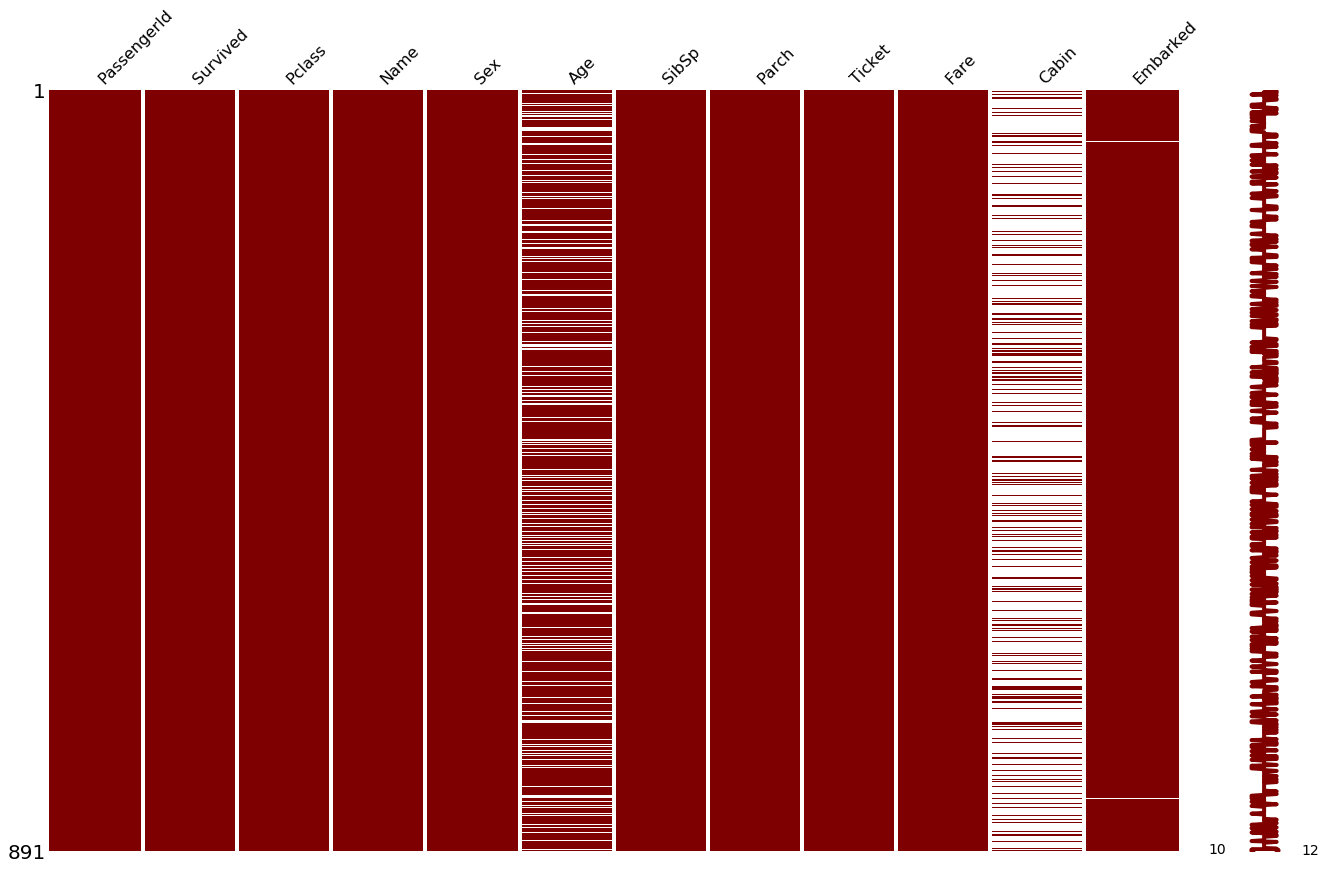

In [11]:
# missing data?
import missingno as msno
msno.matrix(df=train, figsize=(20,14), color=(0.5,0,0))

# Target

Text(0, 0.5, '#')

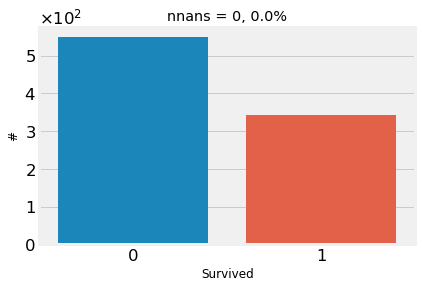

In [12]:
# hist
target = "Survived"
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.countplot(x=target, data=train, ax=ax)
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style="sci",  axis="x",scilimits=(0,0))
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
ax.set_title("nnans = {}, {}%".format(train[target].isna().sum(), 100 * train[target].isna().sum() / train.shape[0]))
ax.set_xlabel(target)
ax.set_ylabel("#")

In [13]:
# roughly categorize features
features, dense_features, cat_features = categorize_features(train, target, cat_threshold=12)

There are 11 features.
There are 3 dense features.
There are 8 categorical features.


# Dense features

In [14]:
vd = DenseVisualizer(train=train, test=test, features=dense_features, target=target)
chkd = vd.column_checker()

feature name = PassengerId
feature name = Age
feature name = Fare


In [15]:
chkd.style.background_gradient()

,features,train_nans,test_nans,train_nunique,test_nunique,train_min,test_min,train_max,test_max,train_mean,test_mean,train_skew,test_skew
0,PassengerId,0,0,891,418,1,892,891,1309,446,1100.5,0,0
1,Age,177,86,88,79,0.42,0.17,80,76,29.6991,30.2726,0.389108,0.457361
2,Fare,0,1,248,169,0,0,512.329,512.329,32.2042,35.6272,4.78732,3.68721


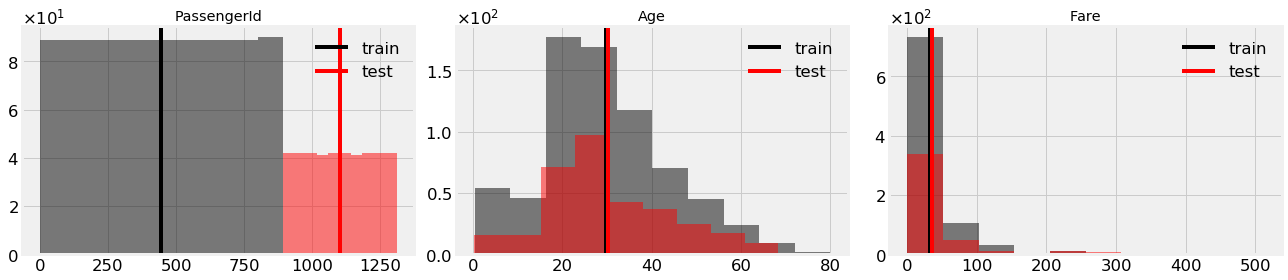

In [16]:
vd.plot_bars()

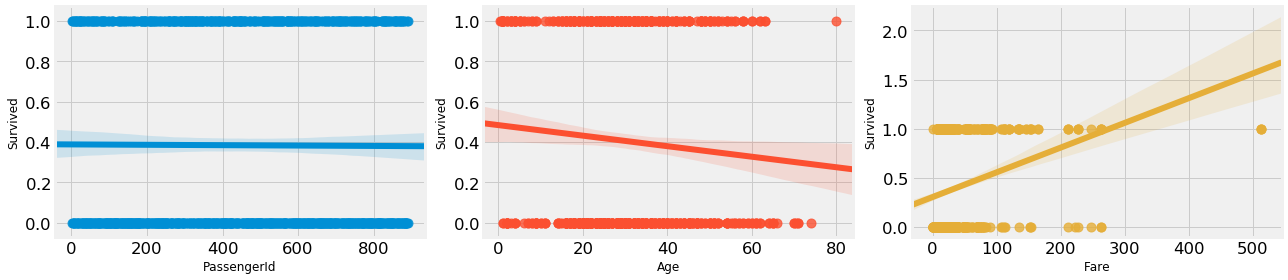

In [17]:
vd.plot_vs_target()

# Categorical features

In [18]:
# EDA for categorical features
vc = CategoricalVisualizer(train=train, test=test, features=cat_features, target=target)
chkc = vc.column_checker()

feature name = Pclass
feature name = Name
feature name = Sex
feature name = SibSp
feature name = Parch
feature name = Ticket
feature name = Cabin
feature name = Embarked


In [19]:
chkc.style.background_gradient()

,features,overlap,train_nans,test_nans,train_nunique,test_nunique
0,Pclass,1,0,0,3,3
1,Name,0.681714,0,0,891,418
2,Sex,1,0,0,2,2
3,SibSp,1,0,0,7,7
4,Parch,0.875,0,0,7,8
5,Ticket,0.733046,0,0,681,363
6,Cabin,0.786096,687,327,147,76
7,Embarked,0.75,2,0,3,3


In [20]:
# remove categorical features which have different values between train and test
cat_features = [c for c in cat_features if chkc.loc[chkc["features"] == c, "overlap"].iloc[0] == 1]
print(len(cat_features))
cat_features

3


['Pclass', 'Sex', 'SibSp']

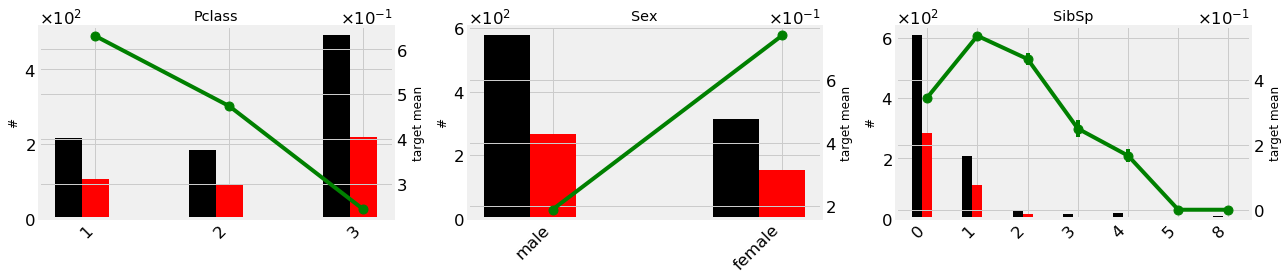

In [21]:
vc = CategoricalVisualizer(train=train, test=test, features=cat_features, target=target)
vc.plot_bars()

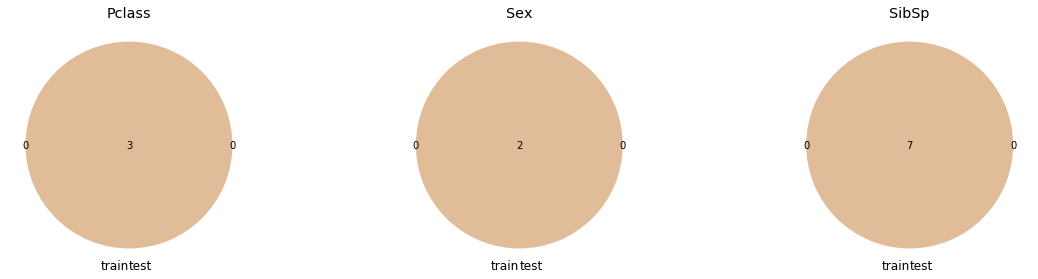

In [22]:
vc.plot_venn()

# Fit LGB and Get Feature importance

In [23]:
# label encoding object features
train, test = label_encoding(train, test, features)

In [24]:
train[target].isna().sum()

0

In [25]:
target in features

False

In [26]:
# fit LGB
features = dense_features + cat_features
lgbcls = LgbClassifier(train, test, target, features, categoricals=cat_features, cv_method="StratifiedKFold")

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.962731	valid_1's auc: 0.81948
Early stopping, best iteration is:
[14]	training's auc: 0.90282	valid_1's auc: 0.837767
Partial score of fold 0 is: 0.8377672322883711
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.953288	valid_1's auc: 0.877672
Early stopping, best iteration is:
[14]	training's auc: 0.878607	valid_1's auc: 0.896894
Partial score of fold 1 is: 0.8968938740293357
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.954858	valid_1's auc: 0.848265
Early stopping, best iteration is:
[6]	training's auc: 0.88545	valid_1's auc: 0.855047
Partial score of fold 2 is: 0.8550474547023296
Our oof loss score is:  0.8616596896004431


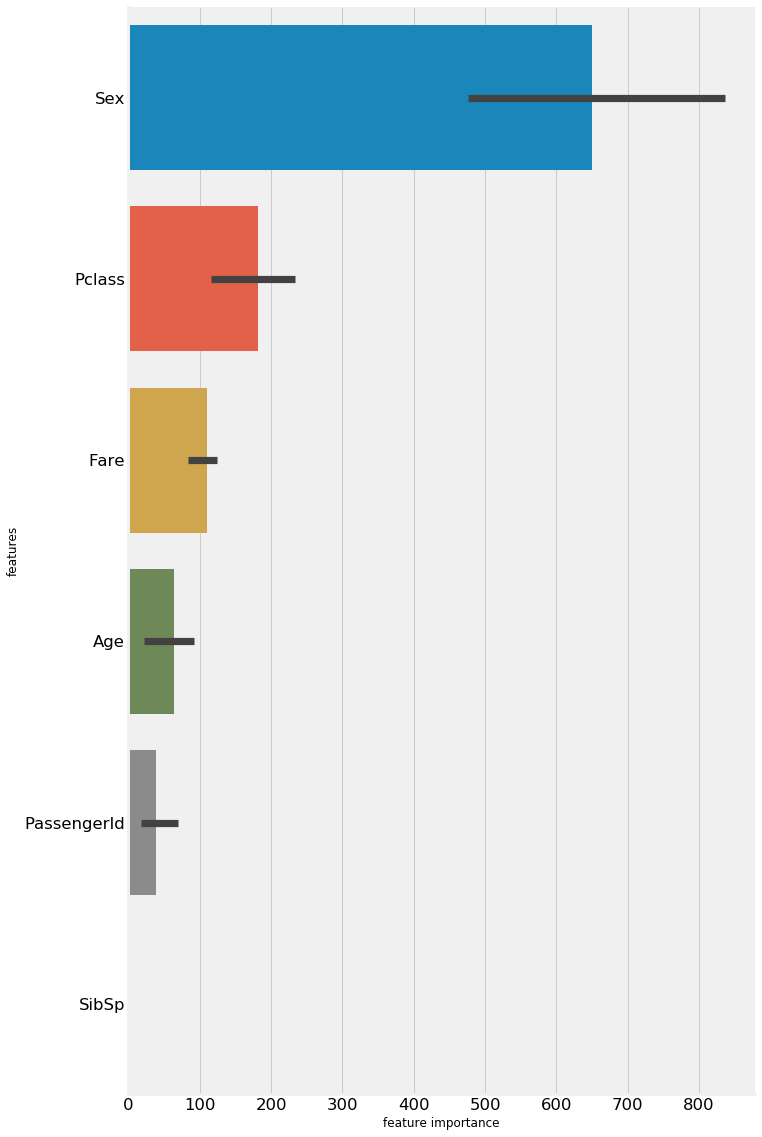

In [27]:
# plot feature importance
lgbcls.plot_feature_importance(rank_range=[1,100])